In [ ]:
! pip install transformers

In [ ]:
import re
import gensim
from nltk.corpus import stopwords
import nltk

# load stopwords
nltk.download('stopwords')
en_stopwords = stopwords.words('english')
additional_stop = ["hello", "doctor", "january", "february", "march", "april", 
                   "may", "june", "july", "august", "september", "october", "november", "december",
                   "hi", "would", "also", "yes", "no", "please", "hello", "thank", "thanks", "regards"]
stops = additional_stop + en_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# split the corpus and calculate the average sentence length
def average_length(path):
  material = open(path, 'r').read().splitlines()
  output = []
  length = 0
  tt = []
  for sent in material:
    temp = sent.split()
    length += len(temp)
    tt.append(len(temp))
    output.append(temp)
  return length/len(material), material, tt

In [ ]:
# check the average length of sentences in each corpus
avg_len_COPD_train2, clean_COPD_train2, lengths1 = average_length("clean_COPD_train2.txt")
print(avg_len_COPD_train2)

avg_len_pneumonia, clean_pneumonia, lengths3 = average_length("clean_pneumonia2.txt")
print(avg_len_pneumonia)

In [ ]:
print("Dataset size:")
print("COPD_train: %d" % (len(clean_COPD_train2)))
print("pneumonia: %d" % (len(clean_pneumonia)))

Dataset size:
COPD_train: 6219
pneumonia: 1401


(array([603., 450., 238.,  70.,  20.,   7.,   6.,   3.,   2.,   2.]),
 array([  4. ,  18.6,  33.2,  47.8,  62.4,  77. ,  91.6, 106.2, 120.8,
        135.4, 150. ]),
 <a list of 10 Patch objects>)

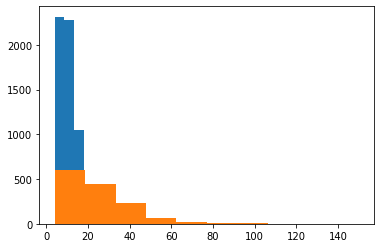

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lengths1)
plt.hist(lengths3)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text_train = clean_COPD_train2 + clean_pneumonia
labels = np.concatenate((np.ones(len(clean_COPD_train2), dtype=np.int32), np.zeros(len(clean_pneumonia), dtype=np.int32))).reshape(-1)
len(text_train)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

7620

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, input, target):
    self.labels = target
    self.texts = [tokenizer(text, padding='max_length', max_length = 25, truncation=True, return_tensors="pt") for text in input]

  def __len__(self):
    return len(self.labels)

  def get_batch_labels(self, idx):
    return self.labels[idx]

  def get_batch_texts(self, idx):
      return self.texts[idx]

  def __getitem__(self, idx):
      batch_texts = self.get_batch_texts(idx)
      batch_y = self.get_batch_labels(idx)
      return batch_texts, batch_y

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text_train, labels, test_size=0.2, train_size=0.8, random_state=30, shuffle=True)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):
  
  def __init__(self, dropout=0.5):
    super(BertClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Linear(768, 2)
    self.sig = nn.Sigmoid()

  def forward(self, input_id, mask):
    _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
    dropout_output = self.dropout(pooled_output)
    linear_output = self.linear(dropout_output)
    final_layer = self.sig(linear_output)
    return final_layer

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, fbeta_score

In [ ]:
class_percent = [len(clean_COPD_train2), len(clean_pneumonia)]
class_weights = [1-each/len(text_train) for each in class_percent]

weights= torch.tensor(class_weights,dtype=torch.float) + torch.tensor([-0.06,0.1])
print("Class Weights:", weights)

weights = weights.to(device)
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

Class Weights: tensor([0.1239, 0.9161])


In [ ]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, training_label, learning_rate, epochs, criterion):
  
  train = Dataset(train_data, training_label)
  
  train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
  optimizer = Adam(model.parameters(), lr= learning_rate)

  if use_cuda:
    model = model.cuda()
    criterion = criterion.cuda()
  for epoch_num in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    
    for train_input, train_label in tqdm(train_dataloader):
      mask = train_input['attention_mask'].to(device)
      input_id = train_input['input_ids'].squeeze(1).to(device)
      
      output = model(input_id, mask)
              
      train_label = train_label.type(torch.LongTensor)
      train_label = train_label.to(device)
      batch_loss = criterion(output, train_label)
      total_loss_train += batch_loss.item()

      acc = (output.argmax(dim=1) == train_label).sum().item()
      total_acc_train += acc

      model.zero_grad()
      batch_loss.backward()
      optimizer.step()
      
      print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
              | Train Accuracy: {total_acc_train / len(train_data): .3f}')

In [ ]:
def evaluate(model, test_data, testing_label):
  
  test = Dataset(test_data, testing_label)
  test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)

  if use_cuda:
    model = model.cuda()

  y_pred = []
  y_true = []
  with torch.no_grad():
    for test_input, test_label in test_dataloader:
      mask = test_input['attention_mask'].to(device)
      input_id = test_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)
      y_pred.extend(output.argmax(dim=1).tolist())
      y_true.extend(test_label.tolist())

  print('Classification Report:')
  print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
  return fbeta_score(y_true, y_pred, beta=0.8, labels=[1,0], average='macro'), y_true, y_pred

In [ ]:
# training the model
EPOCHS = 6
model = BertClassifier()
LR = 1e-5
train(model, X_train, y_train, LR, EPOCHS, cross_entropy)

In [ ]:
# evaluate the model
evaluate(model, X_test, y_test)

In [ ]:
# save the model
torch.save(model, "/content/model.pth")